## MNIST 분류 문제 실습

In [1]:
from functools import reduce
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import batch_norm

# TensorFlow 내장 MNIST 데이터셋 모듈
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
import tensorflow.contrib.layers as layers
he_init = layers.variance_scaling_initializer()

learning_rate = 0.01

inputs = tf.placeholder(tf.float32, [None, 28*28])
label  = tf.placeholder(tf.float32, [None, 10])
is_training = tf.placeholder(tf.bool) # 배치 정규화 및 dropout 사용시 필요

def conv(inputs, num_filter, ksize, stride, padding, is_training, scope=None):
    bottom_shape = inputs.get_shape().as_list()[3]
    
    with tf.variable_scope(scope):
        W = tf.get_variable("W", [ksize, ksize, bottom_shape, num_filter],
                            initializer=he_init)
        
        x = tf.nn.conv2d(inputs, W, strides=[1, stride, stride, 1],
                         padding=padding)
        x = layers.batch_norm(x, is_training=is_training,
                              decay=0.9, updates_collections=None)
        x = tf.nn.relu(x)
        
    return x

def maxpool(inputs, ksize, stride, padding, scope=None):
    with tf.variable_scope(scope):
        pool = tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1],
                              strides=[1, stride, stride, 1],
                              padding=padding)
    return pool
    
def fc(inputs, num_dims, scope=None):
    bottom_shape = inputs.get_shape().as_list()
    if len(bottom_shape) > 2:
        inputs = tf.reshape(inputs,
                            [-1, reduce(lambda x, y: x*y, bottom_shape[1:])])
        bottom_shape = inputs.get_shape().as_list()
        
    with tf.variable_scope(scope):
        W = tf.get_variable("W", [bottom_shape[1], num_dims],
                            initializer=he_init)
        b = tf.get_variable("b", [num_dims],
                            initializer=tf.constant_initializer(0))
        
        out = tf.matmul(inputs, W) + b
    return out
        
def fc_relu(inputs, num_dims, is_training, scope=None):
    with tf.variable_scope(scope):
        out = fc(inputs, num_dims, scope="fc")
        bn  = layers.batch_norm(out, is_training=is_training,
                                decay=0.9, updates_collections=None)
        relu = tf.nn.relu(bn)
    return relu

In [3]:
x = tf.reshape(inputs, shape=[-1, 28, 28, 1])
conv1 = conv(x, 32, ksize=3, stride=1, 
             padding="SAME", is_training=is_training, scope="conv1")
conv1 = maxpool(conv1, ksize=2, stride=2, 
                padding="SAME", scope="pool1")

conv2 = conv(conv1, 32, ksize=3, stride=1, 
             padding="SAME", is_training=is_training, scope="conv2")
conv2 = maxpool(conv2, ksize=2, stride=2, 
                padding="SAME", scope="pool2")

conv3 = conv(conv2, 32, ksize=3, stride=1, 
             padding="SAME", is_training=is_training, scope="conv3")
conv3 = maxpool(conv3, ksize=2, stride=2, 
                padding="SAME", scope="pool3")

fc1   = fc_relu(conv3, 128, is_training=is_training, scope="fc1")
logit = fc(fc1, 10, scope="logit")

In [4]:
# 테스트 시 사용하는 연산 그래프 정의
pred_op = tf.nn.softmax(logit)
correct = tf.equal(tf.argmax(label, 1), tf.argmax(pred_op, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logit))
opt = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

for step in range(1500):
    batch_X, batch_y = mnist.train.next_batch(128)
    _, loss = sess.run([opt, loss_op], feed_dict={inputs: batch_X, label:batch_y, is_training: True})
    if (step+1)%100 == 0:
        print(step+1, loss)

acc_train = sess.run(accuracy,
    feed_dict={inputs:mnist.train.images, label:mnist.train.labels, is_training: False})
acc_test = sess.run(accuracy,
    feed_dict={inputs:mnist.test.images, label:mnist.test.labels, is_training: False})
print("train_accuracy:", acc_train, "test_accuracy:", acc_test)

100 0.0959367
200 0.0725966
300 0.0341407
400 0.040512
500 0.0132321
600 0.0629032
700 0.0065502
800 0.0601398
900 0.0232257
1000 0.142401
1100 0.00623852
1200 0.0315595
1300 0.0239614
1400 0.0226098
1500 0.00523461
train_accuracy: 0.992309 test_accuracy: 0.9864


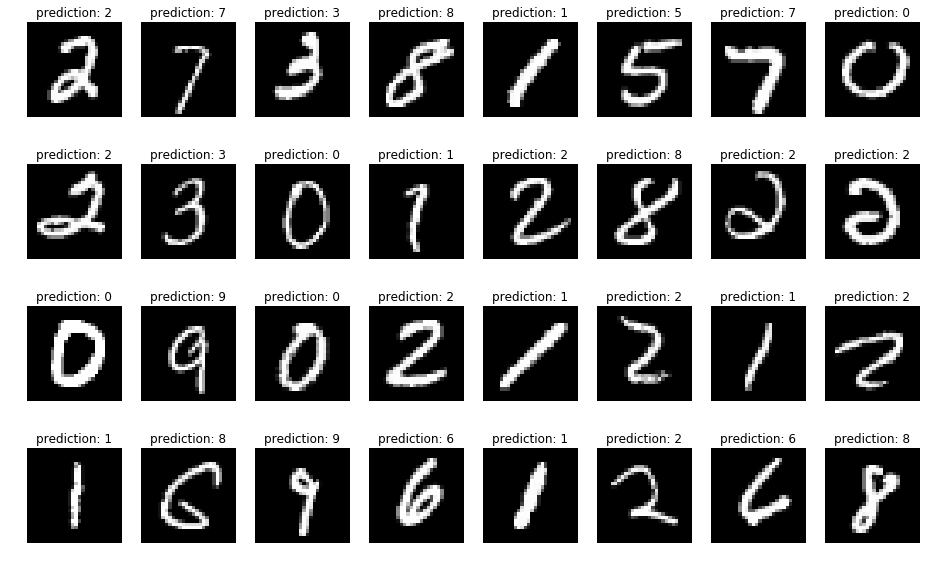

In [5]:
# 테스트 샘플 출력 및 시각화
%matplotlib inline
import matplotlib.pyplot as plt

plot_idx = np.random.randint(0, len(mnist.test.images), 32)

plot_images = mnist.test.images[plot_idx]
plot_labels = mnist.test.labels[plot_idx]
plot_labels = np.argmax(plot_labels, axis=1)

plot_preds = sess.run(pred_op, feed_dict={inputs:plot_images, is_training:False})
plot_preds = np.argmax(plot_preds, axis=1)

fig = plt.figure(figsize=(16, 10))
for i, (img, label, pred) in enumerate(zip(plot_images, plot_labels, plot_preds)):
    a = fig.add_subplot(4, 8, i+1)
    a.set_title("prediction: {}".format(pred))
    a.axis("off")
    plt.imshow(img.reshape(28, 28), cmap="gray")